In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
import pathlib
import numpy as np
import cv2
import skimage
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm  # show progress bar in long loop

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, Add
from tensorflow.keras.optimizers import Adam

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim



In [7]:
def get_image_paths(root_dir):
  """
  This function is to retrive the path of all images based on how the SSID
  dataset has the noisy and ground truth images stored.
  This function might change later if I decide that the dataset I chose was
  too small and end up getting more images from other datasets
  """
  root = pathlib.Path(root_dir)
  img_paths = list(root.rglob("*.PNG*"))  # all images in the SSID dataset are .PNG
  img_paths_lst = [str(path) for path in img_paths]

  gt_lst = []  # gt = ground truth i.e. no noise
  noisy_lst= []
  for p in img_paths_lst:
    # example of a path to an image is /content/drive/My Drive/0012_001_S6_00800_00500_5500_N/GT_SRGB_010.PNG
    img_type = p.split("/")[-1].split('_')[-3]
    if img_type == "NOISY":
      noisy_lst.append(p)
    elif img_type == "GT":
      gt_lst.append(p)

  # more efficient work with np.array
  noisy_array = np.array(noisy_lst)
  gt_array = np.array(gt_lst)    

  return noisy_array, gt_array

def load_img(image_paths):
  """
  Takes a list of paths for images, and loads all those images into memory.
  Return the list of loaded images.
  """
  images = []
  for path in tqdm(image_paths): # loop take a long time to execute so tqdm will show progress bar
      image = cv2.imread(path)  # load image

      # convert colors to RGB instead of BGR since cv2 use BGR by default
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

      image = cv2.resize(image, (128, 128)) # will probably not be needed if using split images from the start

      images.append(image)
        
  return np.array(images)


In [20]:
noisy_array_paths, gt_array_paths = get_image_paths('/content/drive/My Drive/Data')

# create random (seed = 0) train and test images sets from our dataset. Test is 10% of the entire dataset
X_train_paths, X_test_paths, y_train_paths, y_test_paths = train_test_split(noisy_array_paths, gt_array_paths, test_size=0.10, random_state=0, shuffle = True)

X_train = load_img(X_train_paths)
X_test = load_img(X_test_paths)
y_train = load_img(y_train_paths)
y_test = load_img(y_test_paths)


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

In [9]:
# TODO
def split_image(src_dir, save_dir, patch_size):
  """split_images from src_dir to save_dir to small patches of size patch_size x patch_size"""


In [10]:
def CNN_model():
    # encoding
    input_0 = Input(shape=(128,128,3), name="input_layer")
    conv_layer_1 = Conv2D(filters=128, kernel_size=2, padding='same', name="conv_1")(input_0)
    conv_layer_2 = Conv2D(filters=128, kernel_size=2, padding='same', name="conv_2")(conv_layer_1)
    conv_layer_3 = Conv2D(filters=128, kernel_size=2, padding='same', name="conv_3")(conv_layer_2)

    # decoding
    deconv_layer_3 = Conv2DTranspose(filters=128, kernel_size=2, padding='same', name="deconv_3")(conv_layer_3)
    deconv_layer_3 = Add(name="add_2")([conv_layer_2, deconv_layer_3])
    deconv_layer_2 = Conv2DTranspose(filters=128, kernel_size=2, padding='same', name="deconv_2")(deconv_layer_3)
    deconv_layer_1 = Conv2DTranspose(filters=3, kernel_size=2, padding='same', name="deconv_1")(deconv_layer_2)
    decoded = Add(name="add_3")([input_0, deconv_layer_1])

    model = Model(inputs=input_0, outputs=decoded)
    return model

In [11]:
model = CNN_model()

In [119]:
# stop value for training
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, min_delta=0.0001, patience=10)

model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=Adam(learning_rate=0.0001)) # Adam is a popular optimizer for CNN
model.fit(X_train, y_train, epochs=100, verbose=1, validation_data=(X_test, y_test),
          callbacks=[callback])

Epoch 1/100


KeyboardInterrupt: ignored

In [ ]:
path_to_save = "/content/drive/My Drive/denoising_results"
model.save(path_to_save)

INFO:tensorflow:Assets written to: /content/drive/My Drive/desoising_results/assets


In [14]:
path_to_save = "/content/drive/My Drive/denoising_results"
model = tf.keras.models.load_model(path_to_save)

In [30]:
def predict_image(model, noisy_image):
  """Predict 1 image"""
  image = np.expand_dims(noisy_image, axis=0) # takes care of the additional dimension 'None' keras introduces
  predicted_image = model.predict(image)
  return predicted_image[0]
def predict_multiple_images(model, noisy_images):
  """Predict more than 1 image"""
  l=[]
  for img in noisy_images:
    l.append(predict_image(model, img))
  return l
    #predicted_image = model.predict(noisy_images)
    #return predicted_image

In [22]:
def visualize_predictions(model, X_test, y_test, n):
  """Visualize a random n number of noisy, ground truth and predicted images"""
  random_numbers = random.sample(range(X_test.shape[0]), n) # get different images each time
  for i in random_numbers:
    noisy_image = X_test[i]
    gt_image = y_test[i]
    predicted_image = predict_image(model, X_test[i])
    predicted_image /= 255  # representation is [0,1] for imshow instead of [0,255]

    # plot 3 subplots for each image (noisy, ground truth and predicted)
    _ , axs = plt.subplots(1,3, figsize=(48,48))
    axs[0].imshow(noisy_image)
    axs[0].set_title("Noisy image")
    axs[0].set_axis_off()
    axs[1].imshow(gt_image)
    axs[1].set_title("Ground truth image")
    axs[1].set_axis_off()
    axs[2].imshow(predicted_image)
    axs[2].set_title("Predicted image")
    axs[2].set_axis_off()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


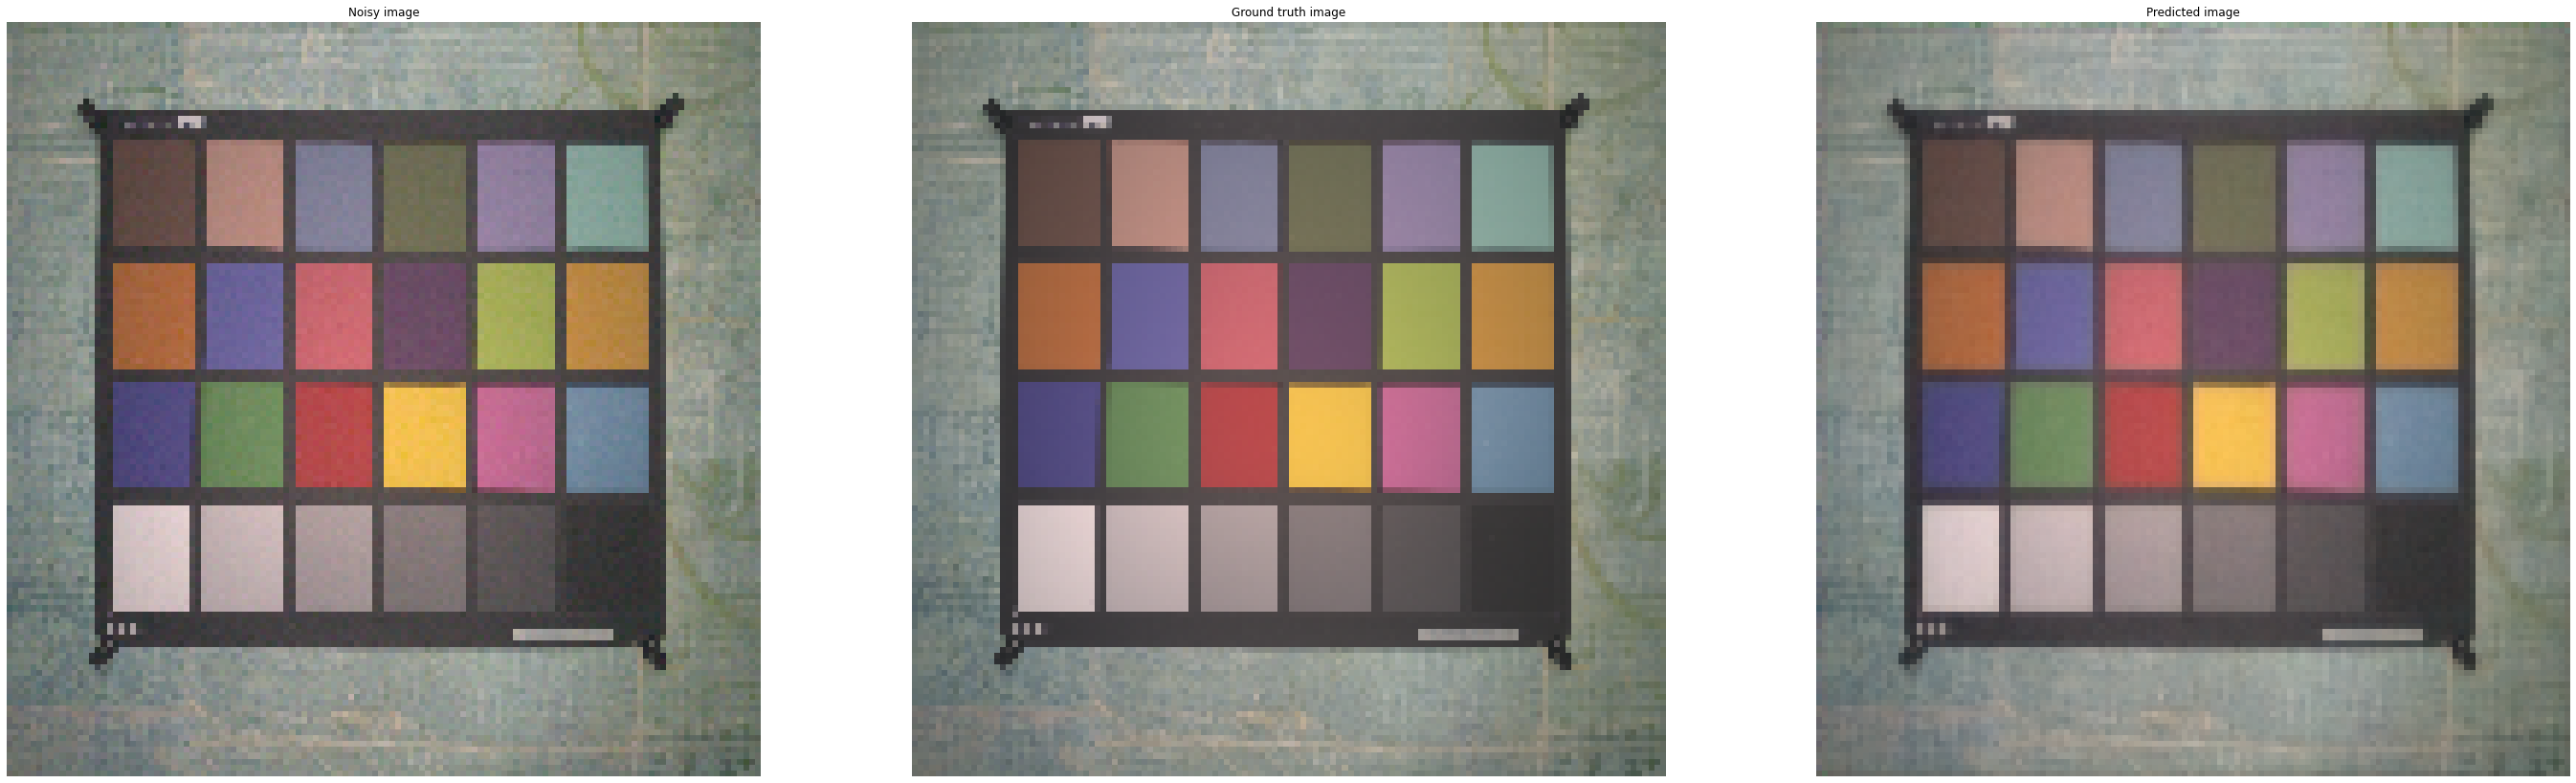

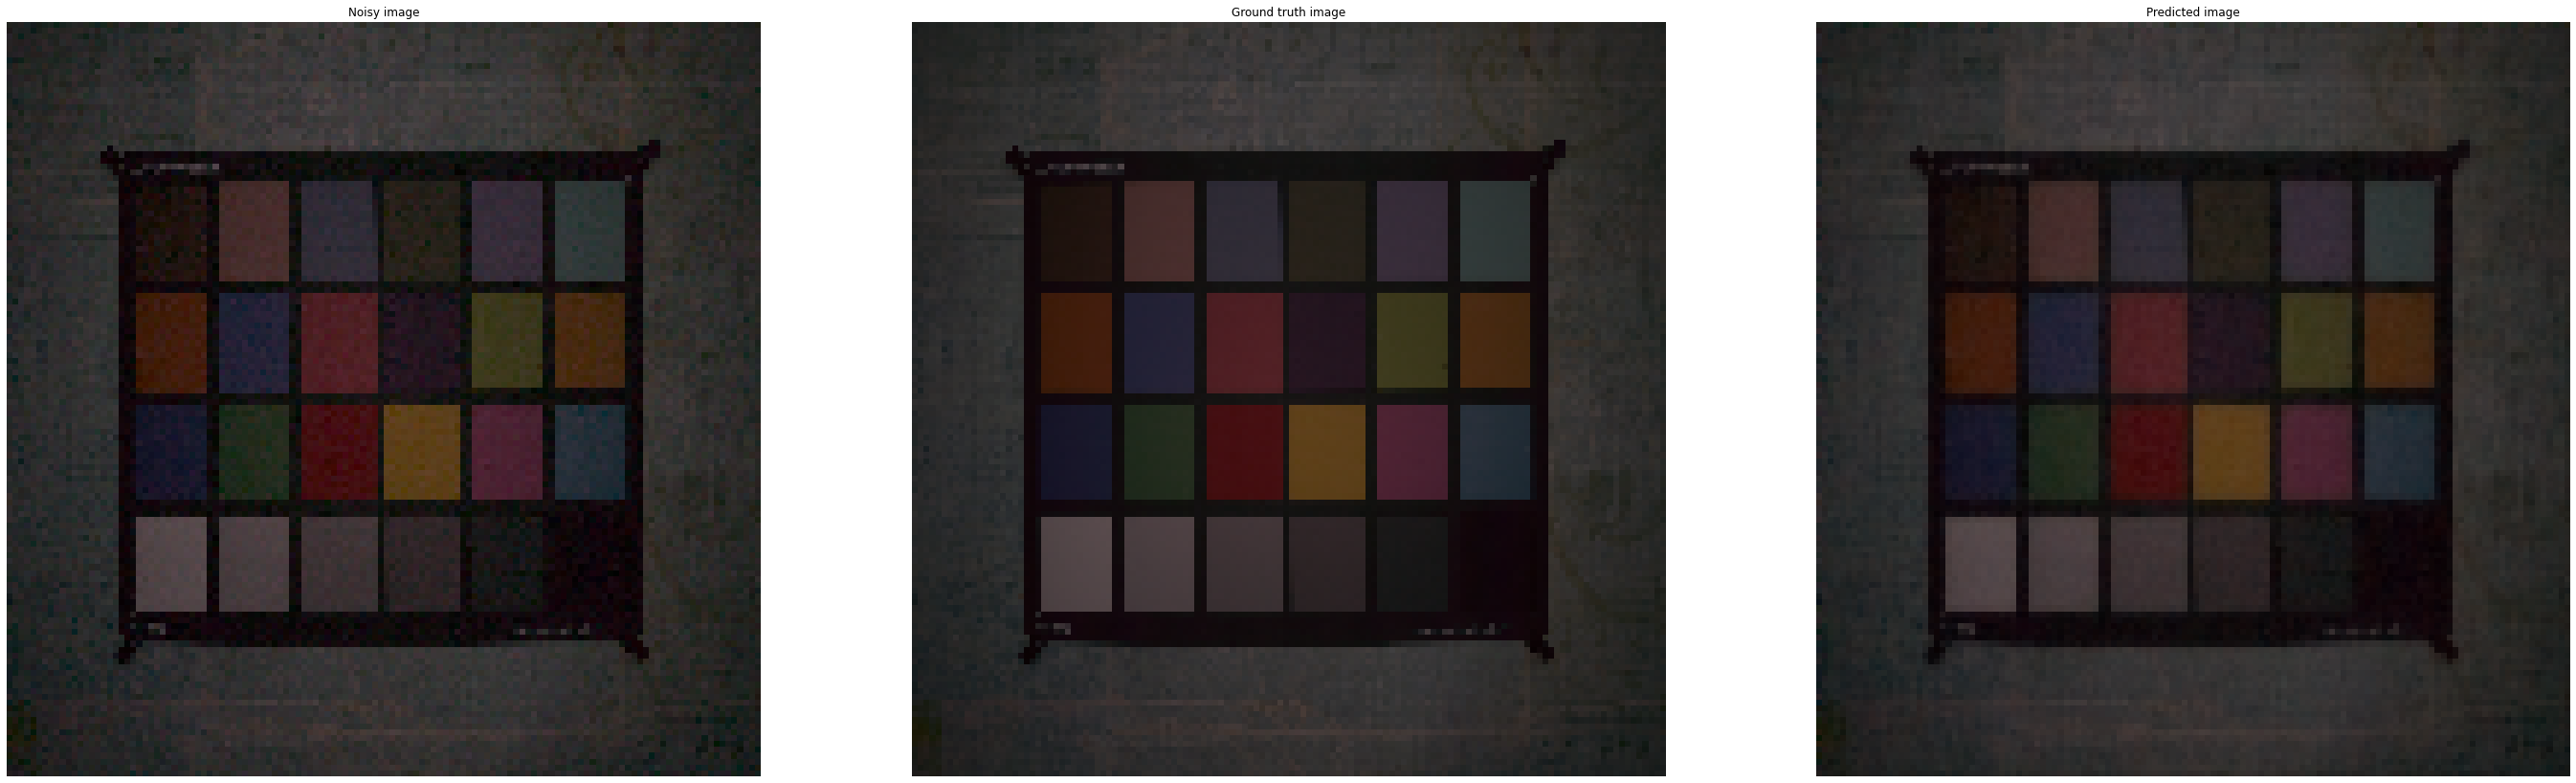

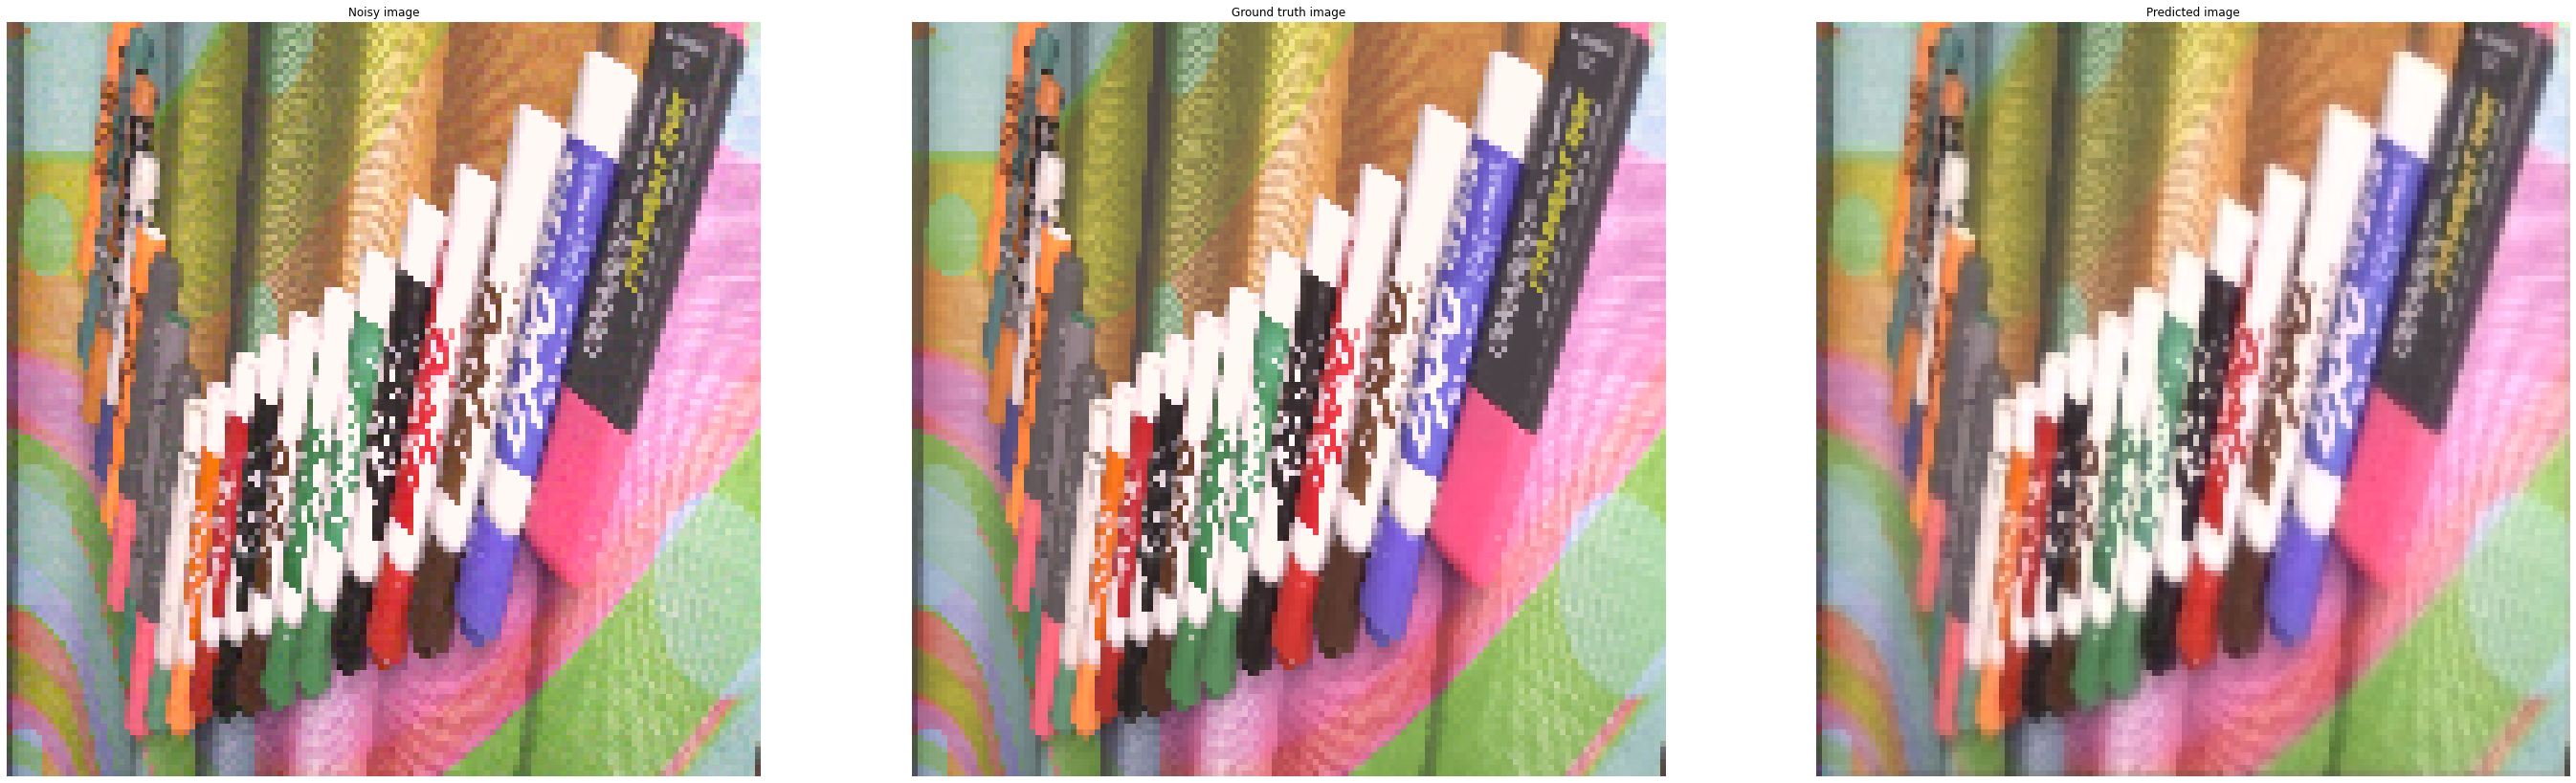

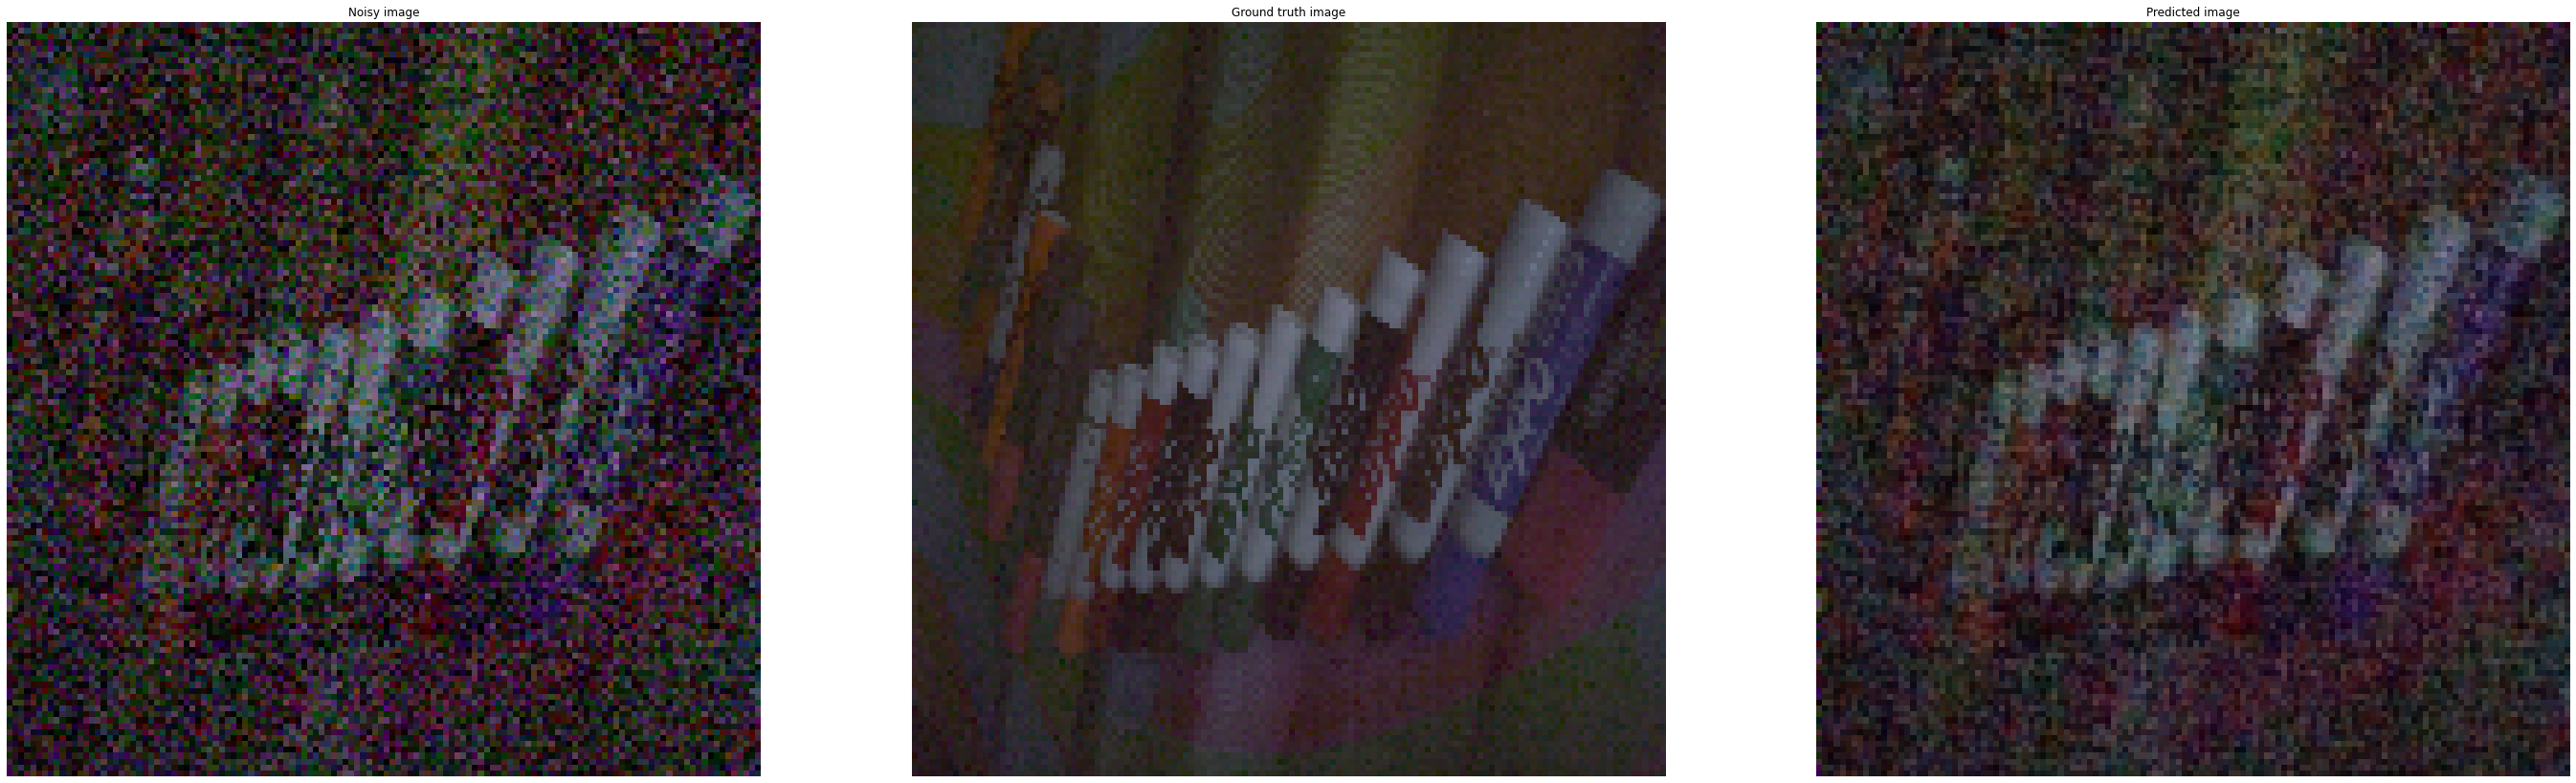

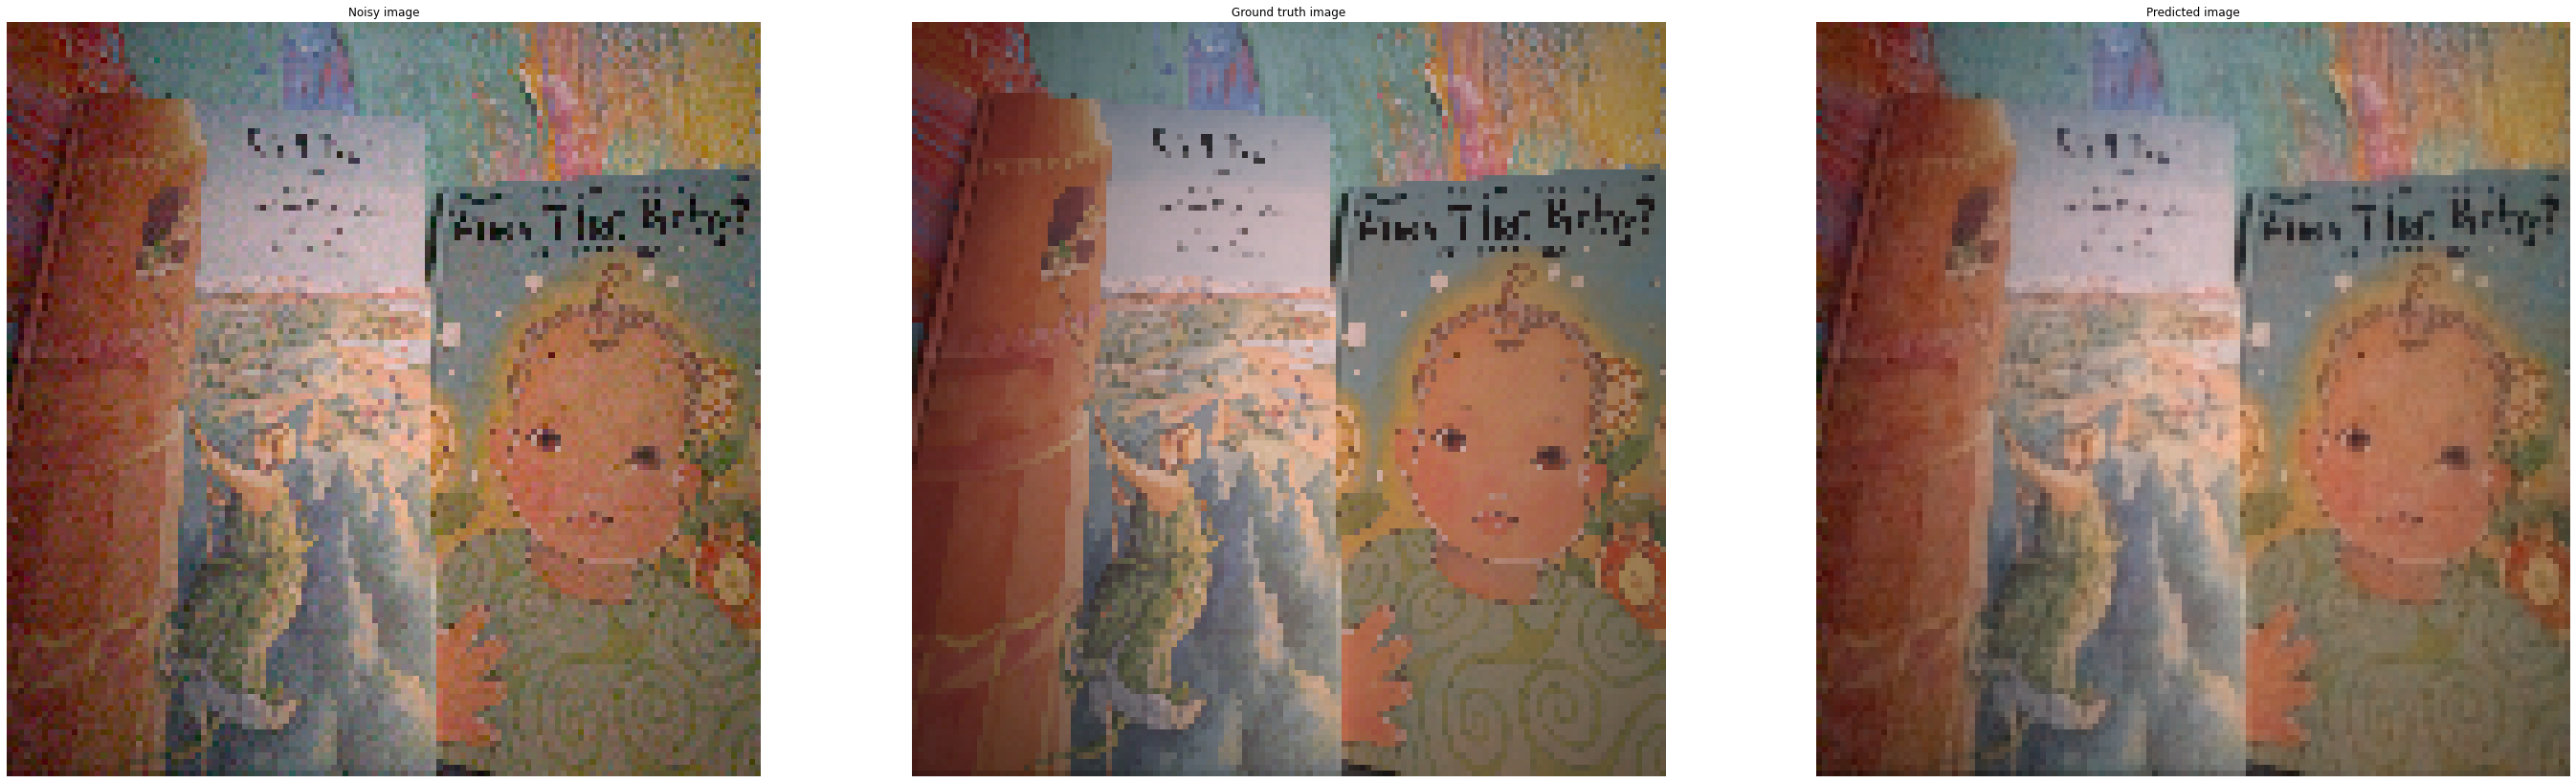

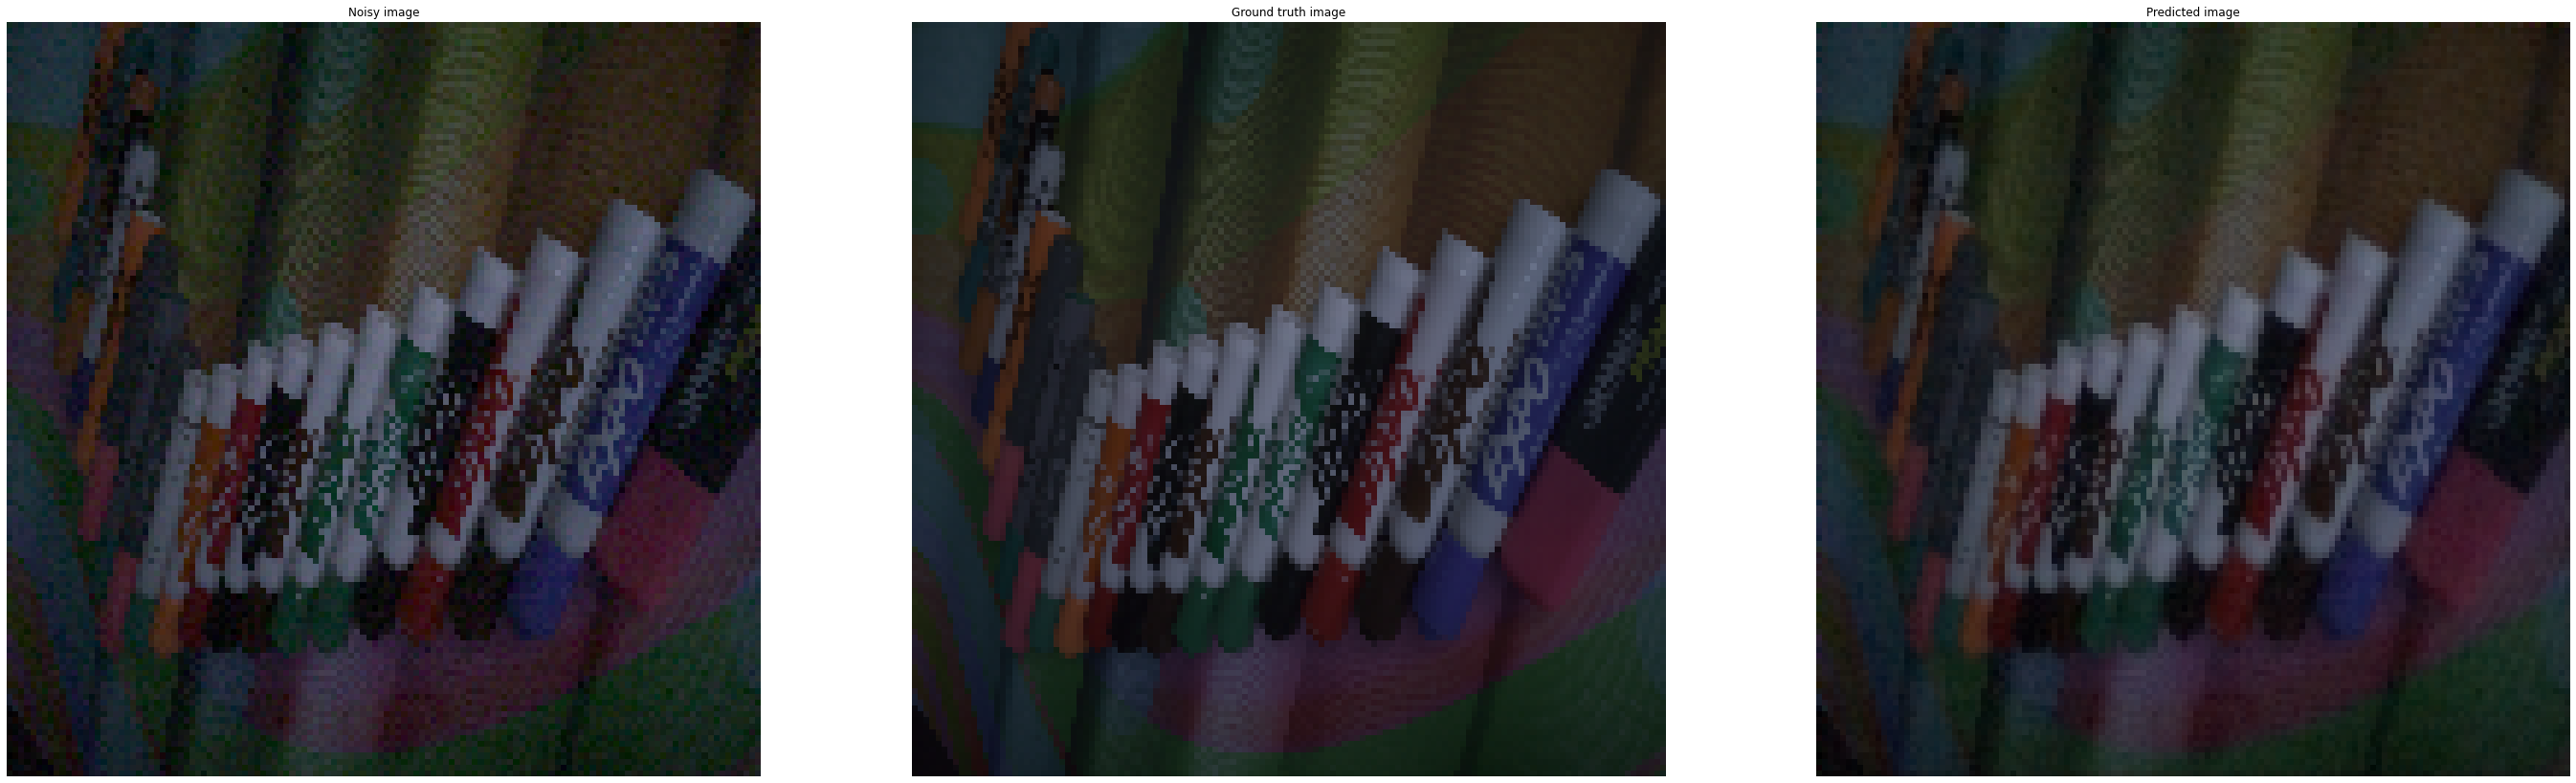

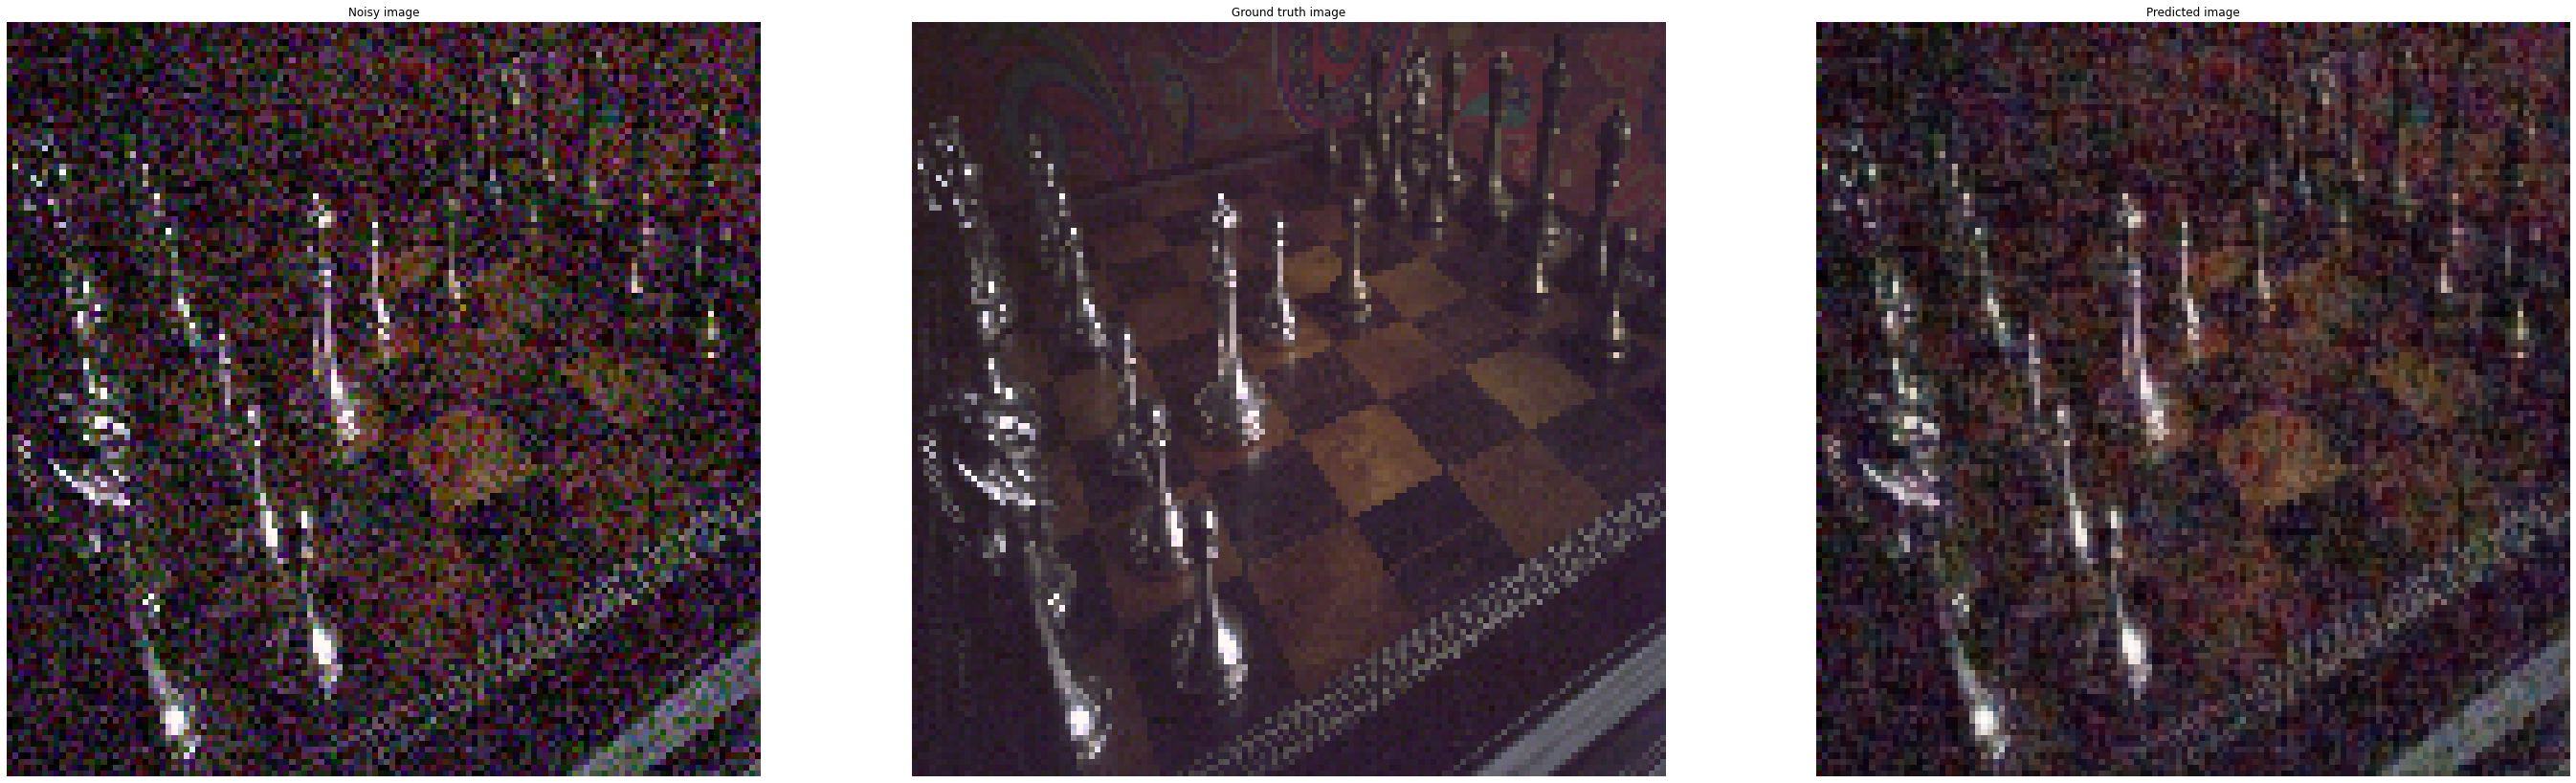

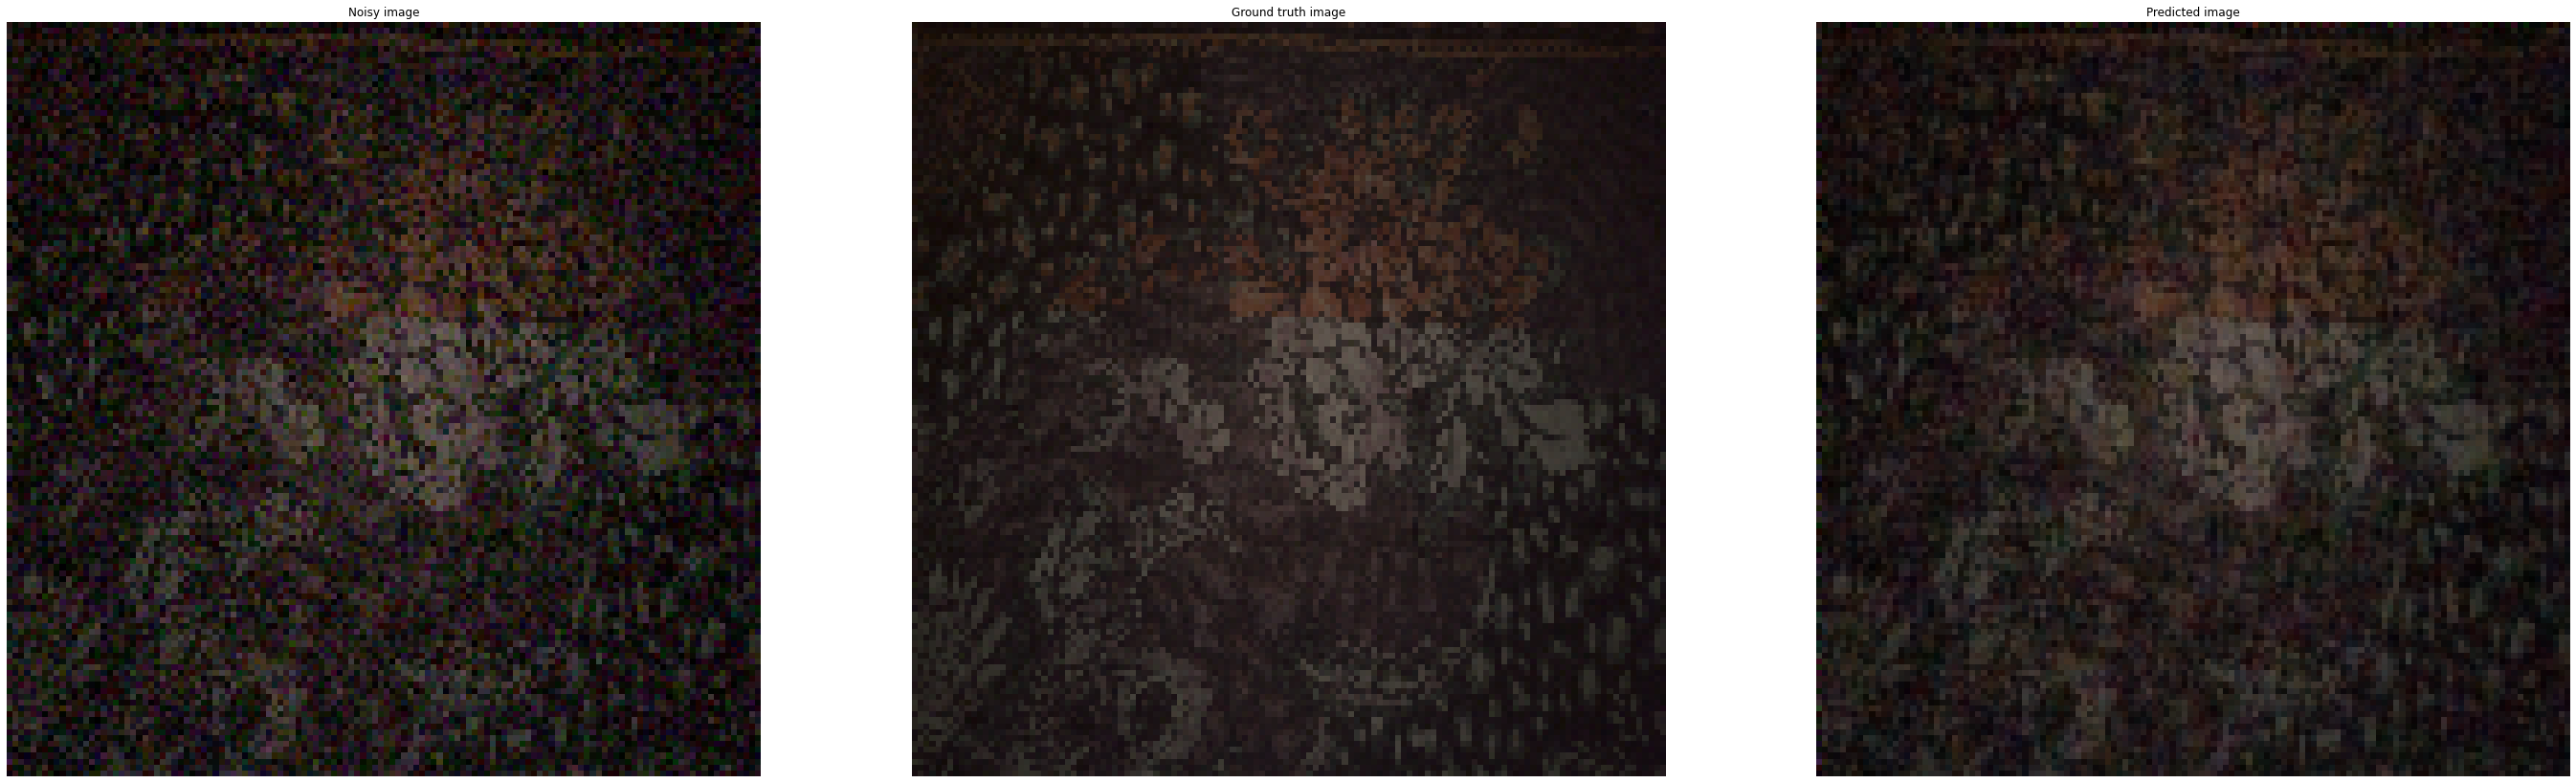

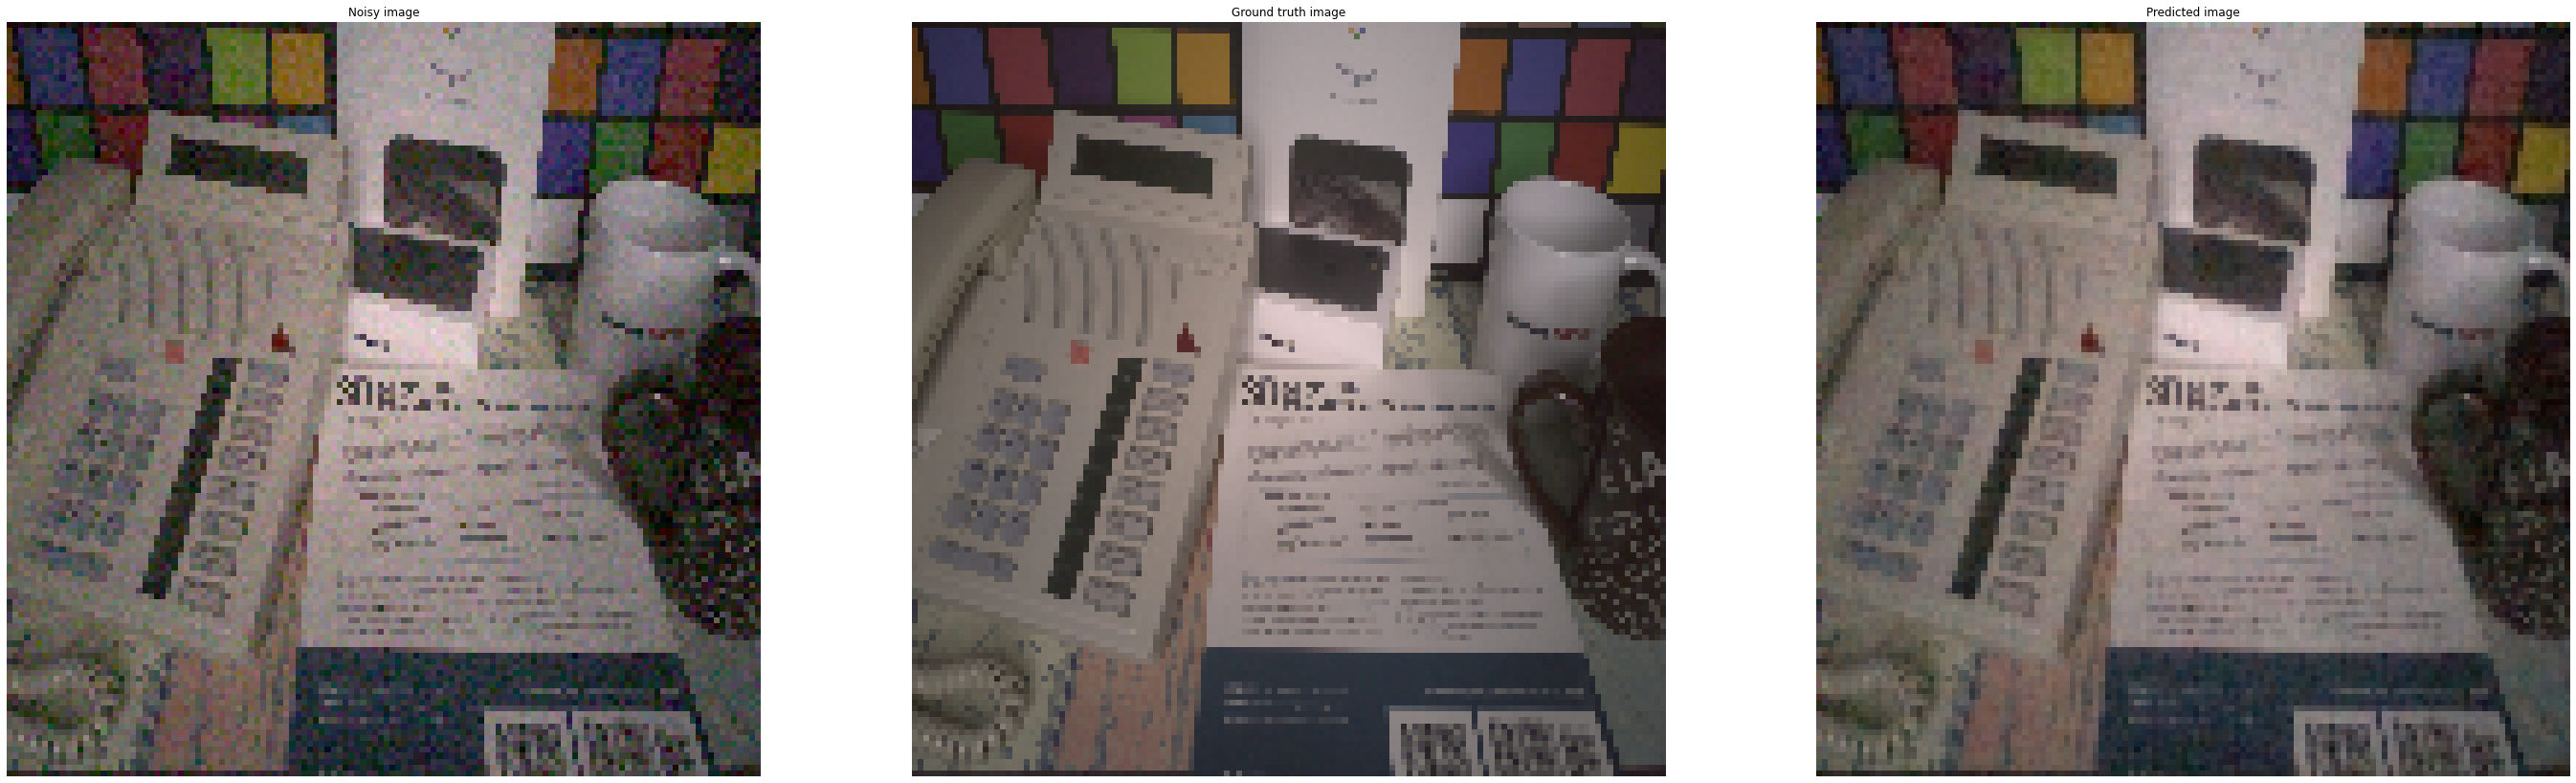

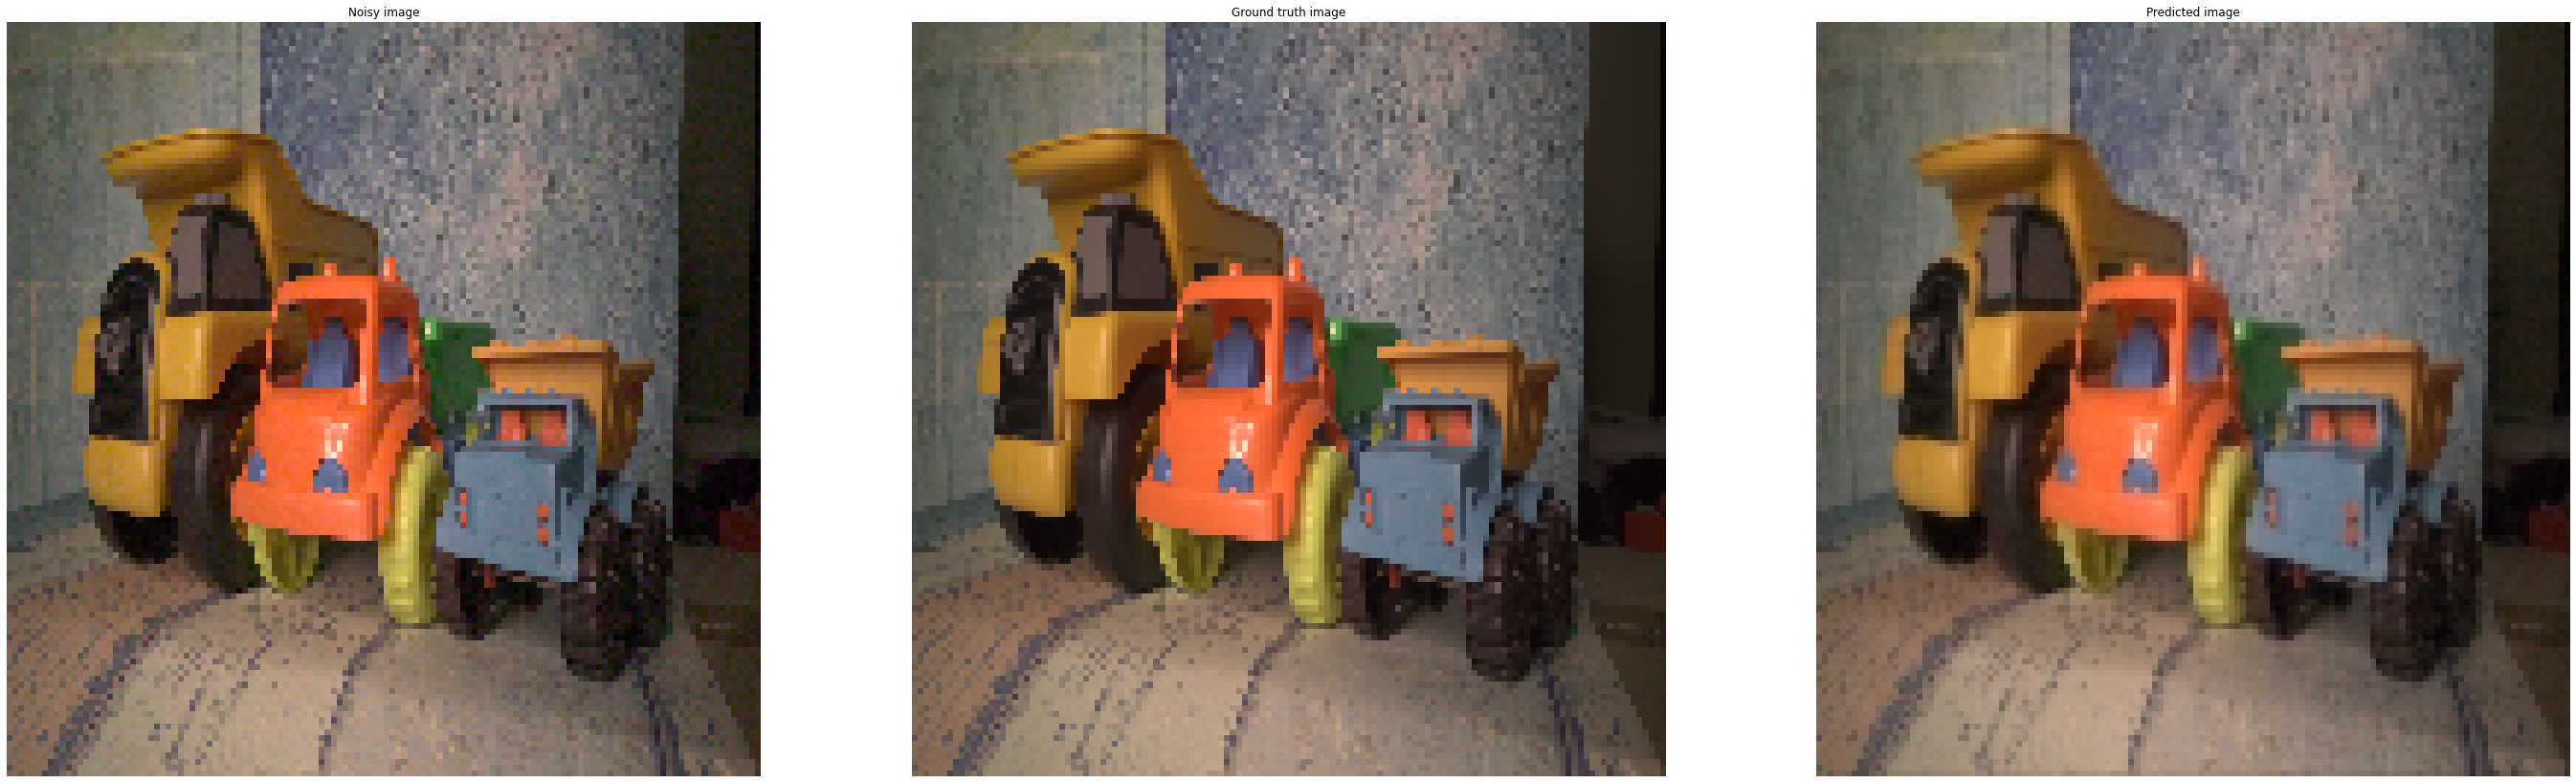

In [27]:
visualize_predictions(model, X_test, y_test, 10)

In [31]:
predicted_images = predict_multiple_images(model, X_test)
sum_psnr_noisy = 0
sum_psnr_prediction = 0

# sum PSNR
for noisy_img, gt_img, predicted_img in zip(X_test, y_test, predicted_images):
    sum_psnr_noisy += psnr(gt_img, noisy_img)
    sum_psnr_prediction += psnr(gt_img, predicted_img)

# get mean of PSNR
psnr_noisy_mean = sum_psnr_noisy / y_test.shape[0]
psnr_prediction_mean = sum_psnr_prediction / y_test.shape[0]
print("The avergae PSNR of the noisy images is", psnr_noisy_mean)
print("The average PSNR of the predicted images is", psnr_prediction_mean)

The avergae PSNR of the noisy images is 29.436034710455065
The average PSNR of the predicted images is 31.212302696322233


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  


In [32]:
predicted_images = predict_multiple_images(model, X_test)
sum_ssim_noisy = 0
sum_ssim_prediction = 0

for noisy_img, gt_img, predicted_img in zip(X_test, y_test, predicted_images):
    sum_ssim_noisy += ssim(gt_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
    sum_ssim_prediction += ssim(gt_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())

ssim_noisy_mean = sum_ssim_noisy / y_test.shape[0]
ssim_prediction_mean = sum_ssim_prediction/ y_test.shape[0]
print("The avergae SSIM of the noisy images is", ssim_noisy_mean)
print("The avergae SSIM of the noisy images is", ssim_prediction_mean)

The avergae SSIM of the noisy images is 0.7566518366005427
The avergae SSIM of the noisy images is 0.8418631902764688
